In [387]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Loading Data

In [388]:
baby_meta_df= pd.read_csv('baby_meta.csv', dtype={'salesRank': dict}) 

In [390]:
baby_cluster_df = pd.read_csv('baby_2000_2_cluster_df.csv')[['asin', 'clusterId']]

In [391]:
products_count_df = baby_cluster_df.groupby('clusterId').count()\
                    .rename(index=str, columns={"asin": "product_count"}).reset_index()

In [392]:
baby_rating_df = pd.read_csv('ratings_Baby.csv', names = ['reviewerID', 'asin', 'overall', 'unixReviewTime']) 

In [393]:
baby_rating_df['time_by_day']=baby_rating_df['unixReviewTime']/86400

In [394]:
baby_rating_df = baby_rating_df.loc[baby_rating_df['time_by_day']>=14610]

# Finding Cluster Attributes

## Product Summary

In [395]:
cols = ['asin', 'rating_count', 'avg_rating'\
        , 'rating_count_2010', 'avg_rating_2010'\
        , 'rating_count_2011', 'avg_rating_2011'\
        , 'rating_count_2012', 'avg_rating_2012'\
        , 'rating_count_2013', 'avg_rating_2013'\
        , 'rating_count_2014', 'avg_rating_2014']

In [396]:
baby_product_rating_summary_df=pd.read_csv('baby_product_rating_summary.csv')[cols]

In [398]:
baby_product_summary_df = baby_product_rating_summary_df.join(baby_meta_df.set_index('asin'), on='asin')\
                            .join(baby_cluster_df.set_index('asin'), on='asin')

In [399]:
baby_cluster_x_rating_df = baby_cluster_df.join(baby_rating_df.set_index('asin'), on='asin')

In [400]:
baby_cluster_x_rating_summary_df = baby_cluster_df.\
                                    join(baby_product_rating_summary_df.set_index('asin'), on='asin')

## Cluster rating attributes

In [401]:
def theil_index(array):
    mean = np.mean(array)
    count = len(array)-np.isnan(array).sum()
    return np.sum(((array/mean)*np.log(array/mean))/count)

In [402]:
def create_cluster_rating_theil_index_df(cluster_x_rating_df):
    return pd.DataFrame(data=cluster_x_rating_df.groupby('clusterId').overall.apply(theil_index))\
            .rename(index=str, columns={"overall": "cluster_rating_theil_index"})

In [403]:
def create_cluster_weighted_avg_rating_df(cluster_x_rating_df):
    return pd.DataFrame(data=cluster_x_rating_df.groupby('clusterId').overall.mean())\
            .rename(index=str, columns={"overall": "cluster_weighted_avg_rating"})

In [404]:
def create_cluster_avg_rating_df(cluster_x_rating_summary_df):
    return cluster_x_rating_summary_df.groupby('clusterId').avg_rating.mean().to_frame()\
        .rename(index=str, columns={"avg_rating": "cluster_avg_rating"})

In [405]:
def create_cluster_avg_rating_var_df(cluster_x_rating_summary_df):
    return pd.DataFrame(data=cluster_x_rating_summary_df.groupby('clusterId').avg_rating.var())\
           .rename(index=str, columns={"avg_rating": "cluster_avg_rating_var"})

In [406]:
def create_cluster_avg_rating_theil_index_df(cluster_x_rating_summary_df):
    return pd.DataFrame(data=cluster_x_rating_summary_df.groupby('clusterId').avg_rating.apply(theil_index))\
            .rename(index=str, columns={"avg_rating": "cluster_avg_rating_theil_index"})

In [407]:
def create_cluster_rating_count_df(cluster_x_rating_summary_df):
    return pd.DataFrame(cluster_x_rating_summary_df.groupby('clusterId').rating_count.sum())\
            .rename(index=str, columns={"rating_count": "cluster_rating_count"})

In [408]:
baby_cluster_x_rating_df.shape

(719639, 6)

In [409]:
def rating_time_correlation(cluster_series):
    return cluster_series['time_by_day'].cov(cluster_series['overall'])\
            /((cluster_series['time_by_day'].var()*cluster_series['overall'].var())**2)

In [410]:
def create_cluster_rating_summary_df(cluster_df, cluster_x_rating_summary_df, cluster_x_rating_df):
    avg_df = create_cluster_avg_rating_df(cluster_x_rating_summary_df)
    avg2_df = create_cluster_weighted_avg_rating_df(cluster_x_rating_df)
    count_df = create_cluster_rating_count_df(cluster_x_rating_summary_df)
    var_df = create_cluster_avg_rating_var_df(cluster_x_rating_summary_df)
    t_df = create_cluster_avg_rating_theil_index_df(cluster_x_rating_summary_df)
    t2_df = create_cluster_rating_theil_index_df(cluster_x_rating_df)
    return avg_df.join(avg2_df).join(count_df).join(var_df).join(t_df).join(t2_df).reset_index()

In [411]:
baby_cluster_rating_summary_df = \
create_cluster_rating_summary_df(baby_cluster_df, baby_cluster_x_rating_summary_df, baby_cluster_x_rating_df)

In [412]:
def create_cluster_avg_rating_by_year_df(cluster_x_rating_summary_df, year):
    return cluster_x_rating_summary_df.groupby('clusterId')['avg_rating_'+str(year)].mean().to_frame()\
        .rename(index=str, columns={"avg_rating_"+str(year): "cluster_avg_rating_"+str(year)})

In [413]:
def create_cluster_rating_summary_by_year_df(cluster_x_rating_df, cluster_x_rating_summary_df, year):
    avg_df = create_cluster_avg_rating_by_year_df(cluster_x_rating_summary_df, year)
    avg2_df = create_cluster_weighted_avg_rating_df(cluster_x_rating_df)\
                .rename(index=str, \
                        columns={"cluster_weighted_avg_rating": "cluster_weighted_avg_rating_"+ str(year)})
    t_df = create_cluster_rating_theil_index_df(cluster_x_rating_df)\
                .rename(index=str, \
                        columns={"cluster_rating_theil_index": "cluster_rating_theil_index_"+str(year)})
    return avg_df.join(avg2_df).join(t_df)

In [414]:
def create_cluster_rating_summary_df_5_years(cluster_x_rating_df, cluster_x_rating_summary_df):
    cluster_x_rating_df_2010=\
    cluster_x_rating_df.loc[(cluster_x_rating_df['time_by_day']>=14610) &\
                            (cluster_x_rating_df['time_by_day']< 14975)]
    cluster_x_rating_df_2011=\
    cluster_x_rating_df.loc[(cluster_x_rating_df['time_by_day']>=14975) &\
                            (cluster_x_rating_df['time_by_day']< 15340)]
    cluster_x_rating_df_2012=\
    cluster_x_rating_df.loc[(cluster_x_rating_df['time_by_day']>=15340) &\
                            (cluster_x_rating_df['time_by_day']< 15706)]
    cluster_x_rating_df_2013=\
    cluster_x_rating_df.loc[(cluster_x_rating_df['time_by_day']>=15706) &\
                            (cluster_x_rating_df['time_by_day']< 16071)]
    cluster_x_rating_df_2014=\
    cluster_x_rating_df.loc[cluster_x_rating_df['time_by_day']>=16071]
    dfs_sum = []
    dfs = [cluster_x_rating_df_2010, cluster_x_rating_df_2011, cluster_x_rating_df_2012, \
          cluster_x_rating_df_2013, cluster_x_rating_df_2014] 
    year = 2010
    for df in dfs: 
        dfs_sum.append(create_cluster_rating_summary_by_year_df(df, cluster_x_rating_summary_df, year))
        year += 1
    return dfs_sum[0].join(dfs_sum[1]).join(dfs_sum[2]).join(dfs_sum[3]).join(dfs_sum[4]).reset_index()
        
        
        
    

In [415]:
baby_cluster_rating_summary_df_5_years = \
create_cluster_rating_summary_df_5_years(baby_cluster_x_rating_df, baby_cluster_x_rating_summary_df)

## Cluster price attributes

In [416]:
def create_cluster_price_var_df(cluster_x_meta_df):
    return pd.DataFrame(data=cluster_x_meta_df.groupby('clusterId').price.var())\
           .rename(index=str, columns={"price": "cluster_price_var"})

In [417]:
def create_cluster_price_theil_index_df(cluster_x_meta_df):
     return pd.DataFrame(data=cluster_x_meta_df.groupby('clusterId').price.apply(theil_index))\
            .rename(index=str, columns={"price": "cluster_price_theil_index"})

In [418]:
def create_cluster_price_summary_df(cluster_df, meta_df):
    cluster_x_meta_df = cluster_df.join(meta_df.set_index('asin'), on='asin')
    var_df = create_cluster_price_var_df(cluster_x_meta_df)
    t_df = create_cluster_price_theil_index_df(cluster_x_meta_df)
    return var_df.join(t_df).reset_index()

In [419]:
baby_cluster_price_summary_df = create_cluster_price_summary_df(baby_cluster_df, baby_meta_df)

## Combine attributes

In [420]:
pd.options.display.max_columns = 20
pd.options.display.max_rows = 800

In [421]:
baby_cluster_summary_df = baby_cluster_rating_summary_df.join(baby_cluster_price_summary_df.\
                                                              set_index('clusterId'), on='clusterId')
#baby_cluster_summary_df['clusterId'] = baby_cluster_summary_df['clusterId'].astype(int)
baby_cluster_summary_df =baby_cluster_summary_df.join(products_count_df.set_index('clusterId'), on='clusterId')
baby_cluster_summary_df['ratings per product']= baby_cluster_summary_df['cluster_rating_count']/baby_cluster_summary_df['product_count']

In [422]:
#baby_cluster_df.loc[baby_cluster_df['clusterId'].isin(filtered['clusterId'].values.astype(int))]\
#.to_csv('filtered_baby_cluster_df.csv')

# Cluster indices

In [423]:
baby_cluster_summary_df['price_distortion_index'] = \
baby_cluster_summary_df['cluster_avg_rating_theil_index']/(1+baby_cluster_summary_df['cluster_price_theil_index'])
baby_cluster_summary_df.loc[baby_cluster_summary_df.product_count == 1, 'price_distortion_index'] = 0
baby_cluster_summary_df['market_frag'] = \
baby_cluster_summary_df['cluster_rating_theil_index']/(np.log(3+baby_cluster_summary_df['product_count']))
baby_cluster_summary_df['user_dis'] = \
float(1)/(baby_cluster_summary_df['cluster_weighted_avg_rating'])#*baby_cluster_summary_df['cluster_rating_theil_index'])


In [425]:
baby_cluster_rating_summary_df_5_years.head()

,clusterId,cluster_avg_rating_2010,cluster_weighted_avg_rating_2010,cluster_rating_theil_index_2010,cluster_avg_rating_2011,cluster_weighted_avg_rating_2011,cluster_rating_theil_index_2011,cluster_avg_rating_2012,cluster_weighted_avg_rating_2012,cluster_rating_theil_index_2012,cluster_avg_rating_2013,cluster_weighted_avg_rating_2013,cluster_rating_theil_index_2013,cluster_avg_rating_2014,cluster_weighted_avg_rating_2014,cluster_rating_theil_index_2014
0,0,3.104396,3.297101,0.118269,1.595833,1.915493,0.192161,2.175000,2.206897,0.204532,2.560317,2.500000,0.232665,3.416667,2.888889,0.207689
1,1,3.741667,4.055556,0.043145,4.130000,4.516129,0.023638,4.548571,4.369565,0.040634,4.353408,4.131579,0.054507,4.500000,4.333333,0.005782
2,2,3.990026,3.804598,0.082531,4.257129,3.959322,0.061063,4.118646,3.997674,0.070189,4.192801,4.193774,0.050494,4.025596,4.018750,0.067251
3,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.397436,4.400000,0.044068,4.507143,4.517241,0.024973
4,4,3.841667,3.810345,0.096508,3.669564,3.476190,0.116731,3.855366,3.601732,0.116248,3.941585,3.875776,0.082722,3.698201,3.694915,0.105905


In [426]:
baby_cluster_summary_df_5_years = pd.DataFrame()
baby_cluster_summary_df_5_years['clusterId'] = baby_cluster_summary_df['clusterId']
for year in [2010, 2011, 2012, 2013, 2014]:
    baby_cluster_summary_df_5_years['market_frag_'+str(year)]=\
        baby_cluster_rating_summary_df_5_years['cluster_rating_theil_index_'+str(year)]/\
        (np.log(3+baby_cluster_summary_df['product_count']))
    baby_cluster_summary_df_5_years['user_dis_'+str(year)]=\
        float(1)/baby_cluster_rating_summary_df_5_years['cluster_weighted_avg_rating_'+str(year)]


In [427]:
baby_cluster_summary_df = baby_cluster_summary_df.loc[(baby_cluster_summary_df['cluster_rating_count'] >= 80) &\
                           (baby_cluster_summary_df['product_count'] >= 20) ]

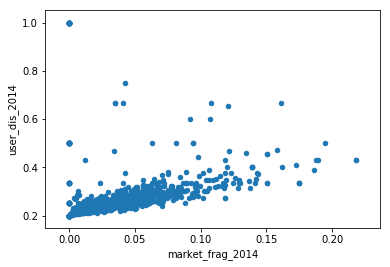

In [428]:
baby_cluster_summary_df_5_years.plot.scatter(x='market_frag_2014', y ='user_dis_2014')

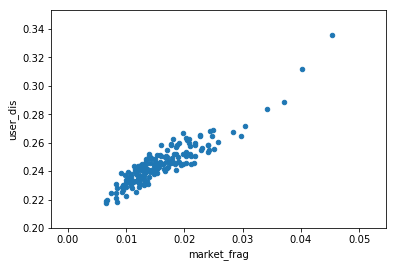

In [429]:
baby_cluster_summary_df.plot.scatter(x='market_frag', y ='user_dis')

In [430]:
import plotly.offline as pyo
import plotly.graph_objs as go

pyo.init_notebook_mode(True)

In [431]:
def plot_metrics(DF):
    trace = go.Scatter(
        x = DF['market_frag'],
        y = DF['user_dis'],
        hoverinfo = 'text',
        marker = {'size': (DF['cluster_rating_count'])**0.5, 'color': ['#ff7f0e' if _id == '1537' else '#1f77b4' for _id in DF['clusterId']]},
        mode = 'markers',
        text = ['ID: {}<br>Products: {}<br>Ratings: {}'
                .format(list(DF['clusterId'])[i], 
                        list(DF['product_count'])[i],
                        list(DF['cluster_rating_count'])[i]) for i in range(DF.shape[0])
               ]
    )
    
    return pyo.iplot(go.Data([trace]))

In [432]:
plot_metrics(baby_cluster_summary_df)

# Viewing Clusters and Products of interest

In [433]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))
pd.set_option('display.expand_frame_repr', False)
pd.set_option('max_colwidth', 300)

## View single product ('asin')

In [434]:
baby_product_summary_df.loc[baby_product_summary_df['asin'] == '0980027500']

,asin,rating_count,avg_rating,rating_count_2010,avg_rating_2010,rating_count_2011,avg_rating_2011,rating_count_2012,avg_rating_2012,rating_count_2013,...,Unnamed: 0,categories,description,title,price,imUrl,brand,related,salesRank,clusterId
9,0980027500,12,4.583333,1.0,5.0,1.0,5.0,4.0,4.75,5.0,...,10,[['Baby']],This calendar provides busy parents with a simple way to note both big and little moments from baby's first year. A sheet of 81 stickers makes the calendar a fast method of recording events and milestones. The aresas provided for photos and additional journaling create a memory book keepsake tha...,Nature's Lullabies First Year Sticker Calendar,9.99,http://ecx.images-amazon.com/images/I/31PYzNf0RBL._SY300_.jpg,NaN,"{'also_bought': ['0980027594', '0980027586', '0307342301', 'B003NMTJGS', 'B004LE8TAE', '0307461971', '1593596103', '0740727303', 'B004LE8TB8', 'B00A695BJU', 'B003UYU0S0', 'B00JJS1QD4', 'B006PJAWDA', 'B00AYZFM8G', '1887169318', 'B0039UULYS', '030746542X', '0064436314', 'B004L2JJAK', 'B0034G5UZC',...",NaN,1032.0


In [435]:
1578

1578

## View products by cluster ('clusterId')

In [440]:
baby_product_summary_df.loc[baby_product_summary_df['clusterId'] == 91]

,asin,rating_count,avg_rating,rating_count_2010,avg_rating_2010,rating_count_2011,avg_rating_2011,rating_count_2012,avg_rating_2012,rating_count_2013,...,Unnamed: 0,categories,description,title,price,imUrl,brand,related,salesRank,clusterId
747,B0001GZ3VE,51,2.960784,5.0,3.000000,21.0,2.619048,8.0,3.000000,13.0,...,1213,[['Baby']],"With 49 MHz technology, lightweight portability and sound lights that let you see baby's activity level, The First Years 49 MHz Two Receiver Monitor enables you to enjoy peace of mind when you're away from your baby. For added convenience, it includes two receivers so you can keep each receiver ...",The First Years Two Receiver 49 MHz Monitor,39.95,http://ecx.images-amazon.com/images/I/41Jm4m-zUrL._SY300_.jpg,NaN,"{'also_bought': ['B002RL7UWQ', 'B004HFQOLI', 'B00A4B34IA', 'B0028OT7G4', 'B003I867US', 'B000LZFZVS'], 'also_viewed': ['B006OTD9WC', 'B003GAMOBY', 'B009Z4UWQY', 'B009Z4UWFU', 'B0017T2RYU', 'B000056OWT', 'B006ZISPIA', 'B004HWDMV6', 'B003GAMOBO', 'B004AHKUHW', 'B00DWJO2IW', 'B007NG5UF4', 'B002WN2BY...",NaN,91.0
1439,B0009T2CB2,7,4.285714,2.0,5.000000,3.0,4.666667,1.0,5.000000,1.0,...,2567,[['Baby']],"SEE and hear baby&#8217;s call! For the mom who wants to stay in touch with baby, this monitor has sound lights that let you not only hear, but actually &#8220;see&#8221; the different levels of your baby&#8217;s activity. There are two channels to minimize interference and for added convenience...",Fisher-Price Sounds 'N Lights Monitor,39.95,http://ecx.images-amazon.com/images/I/313VVX1MJ7L._SY300_.jpg,NaN,"{'also_viewed': ['B007NG5UF4', 'B000S35QLC', 'B004AHKUHM', 'B000WU9CYI', 'B000WU7EKC', 'B003GAMOBO', 'B003G2YUS2', 'B0009T2CBM', 'B009OZMQYU', 'B003GAMOBY', 'B00005TNIH', 'B0017T2RYU', 'B000056OWT', 'B003G2YUSW', 'B006OTD9WC', 'B007NG5UEU', 'B00EL8S3TW', 'B00EL8S9BO', 'B001MTELIK', 'B003FGWA8G',...",NaN,91.0
4772,B000S35QLC,632,2.963608,81.0,3.222222,169.0,2.710059,193.0,2.797927,140.0,...,8502,[['Baby']],"900 MHz Technology extends the range of BabyCall Monitor to let you take the receiver farther from the nursery, yet still hear activities in the nursery. It comes with 27 channels to greatly minimize interference and uses FM transmission system with channel selector to locate the clearest channe...",NTM-910YIC - Sony Baby Call Nursery Monitor,35.95,http://ecx.images-amazon.com/images/I/310oAk6MvhL.jpg,Sony,"{'also_bought': ['B002MQQL44', 'B00DGN23UI', 'B009TJ3J60', 'B006XISCNA', 'B005DLCJX2', 'B0017T2RYU', 'B0045I6IA4', 'B00008439C', 'B00DFFT8JQ', 'B002TLU5JO', 'B007VSQ75Q', 'B00IWOZZZQ', 'B00DFFT9SQ', 'B008HCXIU2', 'B00DDMJ332', 'B0038JDVCE', 'B0000BYAG0', 'B0091E31KM', 'B0009JB3A8', 'B00171WXII',...",NaN,91.0
5724,B000WU7EKC,18,2.000000,13.0,2.153846,4.0,1.750000,1.0,1.000000,NaN,...,9794,[['Baby']],"The new Sounds 'N Lights Monitor includes a sleek contemporary look that is in line with other personal electronics Moms are accustomed to. The lights are now on both sides, allowing greater visibility around the house. This monitor also includes a night-light feature on the transmitter to allow...",Fisher-Price Sounds 'n Lights Monitor with Dual Receiver,52.00,http://ecx.images-amazon.com/images/I/31PZ4uF6sPL._SX300_.jpg,NaN,"{'also_viewed': ['B003GAMOBY', 'B000WU9CYI', 'B0009T2CBM', 'B003GAMOBO', 'B003G2YUS2', 'B004AHKUHW', 'B0017T2RYU', 'B004HWDMV6', 'B007NG5UEU', 'B00005TNIH', 'B007NG5UF4', 'B004AHKUHM', 'B008ETBGES', 'B000S35QLC', 'B00101TXPG', 'B0042AE9EC', 'B006OTD9WC', 'B003GAMOC8', 'B000056OWT', 'B003G2YUT6',...",NaN,91.0
5729,B000WU9CYI,14,2.928571,5.0,3.000000,5.0,3.200000,1.0,3.000000,2.0,...,9802,[['Baby']],"The new Sounds 'N Lights Monitor includes a sleek contemporary look that is in line with other personal electronics Moms are accustomed to. The lights are now on both sides, allowing greater visibility around the house. This monitor also includes a night-light feature on the transmitter to allow...",Fisher-Price Sounds 'n Lights Monitor,45.19,http://ecx.images-amazon.com/image

# Output csv

In [437]:
baby_cluster_summary_df.to_csv('baby_2000_2_cluster_summary.csv')
baby_product_summary_df.to_csv('baby_product_summary_2.csv')